In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
water_quality_data = pd.read_csv("water_quality_training_dataset.csv")
terraclimate_data = pd.read_csv("terraclimate_features_training.csv")
landsat_data = pd.read_csv("landsat_features_training.csv")

print("Water quality shape:", water_quality_data.shape)
print("TerraClimate shape:", terraclimate_data.shape)
print("Landsat shape:", landsat_data.shape)

Water quality shape: (9319, 6)
TerraClimate shape: (9319, 4)
Landsat shape: (9319, 9)


In [8]:
merged_data = water_quality_data.merge(
    terraclimate_data,
    on=['Latitude', 'Longitude', 'Sample Date'],
    how='left'
).merge(
    landsat_data,
    on=['Latitude', 'Longitude', 'Sample Date'],
    how='left'
)

print("Merged shape:", merged_data.shape)

Merged shape: (9319, 13)


In [9]:
targets = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

feature_cols = ['nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', 'pet']

X = merged_data[feature_cols]
y = merged_data[targets]

X = X.fillna(X.mean())

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9319, 7)
y shape: (9319, 3)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (7455, 7)
Test set: (1864, 7)


# Models

- Using the random forest model

In [11]:
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 15, 20, None],        
    'model__min_samples_split': [2, 5, 10],        
    'model__min_samples_leaf': [1, 2, 4],          
    'model__max_features': ['sqrt', 'log2', None]  
}

trained_models = {}

for target in targets:
    print(f"{'='*40}")
    print(f"Fine-tuning model for: {target}")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
    ])
    

    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_dist, 
        n_iter=10,          
        cv=3,              
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    

    search.fit(X_train, y_train[target])
    
    best_model = search.best_estimator_
    trained_models[target] = best_model
    
    print(f"Best Params: {search.best_params_}")
    
    test_score = best_model.score(X_test, y_test[target])
    print(f"Test R² Score: {test_score:.4f}")

Fine-tuning model for: Total Alkalinity
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20}
Test R² Score: 0.5286
Fine-tuning model for: Electrical Conductance
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20}
Test R² Score: 0.5720
Fine-tuning model for: Dissolved Reactive Phosphorus
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'model__n_estimators': 100, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20}
Test R² Score: 0.5427


In [12]:
# print("="*50)
# print("Training Random Forest for: Total Alkalinity")
# print("="*50)

# rf_model_alkalinity = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=20,
#     random_state=42,
#     n_jobs=-1
# )

# start_time = time.time()
# rf_model_alkalinity.fit(X_train, y_train['Total Alkalinity'])
# training_time = time.time() - start_time

# y_pred_alkalinity = rf_model_alkalinity.predict(X_test)

# mse = mean_squared_error(y_test['Total Alkalinity'], y_pred_alkalinity)
# r2 = r2_score(y_test['Total Alkalinity'], y_pred_alkalinity)

# print(f"Training time: {training_time:.2f} seconds")
# print(f"MSE: {mse:.4f}")
# print(f"R² Score: {r2:.4f}")

Training Random Forest for: Total Alkalinity
Training time: 0.34 seconds
MSE: 1009.1841
R² Score: 0.8247


In [13]:
print("="*50)
print("Training Random Forest for: Electrical Conductance")
print("="*50)

rf_model_conductance = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_model_conductance.fit(X_train, y_train['Electrical Conductance'])
training_time = time.time() - start_time

y_pred_conductance = rf_model_conductance.predict(X_test)

mse = mean_squared_error(y_test['Electrical Conductance'], y_pred_conductance)
r2 = r2_score(y_test['Electrical Conductance'], y_pred_conductance)

print(f"Training time: {training_time:.2f} seconds")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Training Random Forest for: Electrical Conductance
Training time: 0.35 seconds
MSE: 16820.7502
R² Score: 0.8591


In [14]:
# print("="*50)
# print("Training Random Forest for: Dissolved Reactive Phosphorus")
# print("="*50)

# rf_model_phosphorus = RandomForestRegressor(
#     n_estimators=100,
#     max_depth=20,
#     random_state=42,
#     n_jobs=-1
# )

# start_time = time.time()
# rf_model_phosphorus.fit(X_train, y_train['Dissolved Reactive Phosphorus'])
# training_time = time.time() - start_time

# y_pred_phosphorus = rf_model_phosphorus.predict(X_test)

# mse = mean_squared_error(y_test['Dissolved Reactive Phosphorus'], y_pred_phosphorus)
# r2 = r2_score(y_test['Dissolved Reactive Phosphorus'], y_pred_phosphorus)

# print(f"Training time: {training_time:.2f} seconds")
# print(f"MSE: {mse:.4f}")
# print(f"R² Score: {r2:.4f}")

Training Random Forest for: Dissolved Reactive Phosphorus
Training time: 0.36 seconds
MSE: 843.3557
R² Score: 0.6858


In [16]:
# Compare train vs test performance for one model
train_pred = rf_model_alkalinity.predict(X_train)
train_r2 = r2_score(y_train['Total Alkalinity'], train_pred)

print(f"Total Alkalinity:")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Test R²: 0.8247")
print(f"  Gap: {train_r2 - 0.8247:.4f}")

Total Alkalinity:
  Training R²: 0.9530
  Test R²: 0.8247
  Gap: 0.1283


# Test

       🚀 FINAL MODEL PERFORMANCE REPORT

🔹 TARGET: Total Alkalinity
   Train R²: 0.8480  |  Train RMSE: 29.0010
   Test R² : 0.5286  |  Test RMSE: 52.0945
   Gap (Overfitting): 0.3195


/var/folders/hv/kxrxx3qn2rz5xqvmhb82grsw0000gn/T/ipykernel_2056/1368798169.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


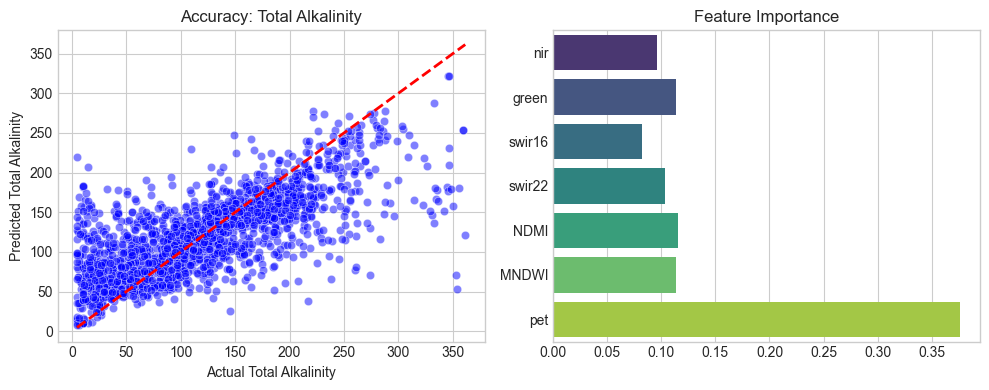

/var/folders/hv/kxrxx3qn2rz5xqvmhb82grsw0000gn/T/ipykernel_2056/1368798169.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


------------------------------------------------------------

🔹 TARGET: Electrical Conductance
   Train R²: 0.8578  |  Train RMSE: 128.5995
   Test R² : 0.5720  |  Test RMSE: 226.0298
   Gap (Overfitting): 0.2857


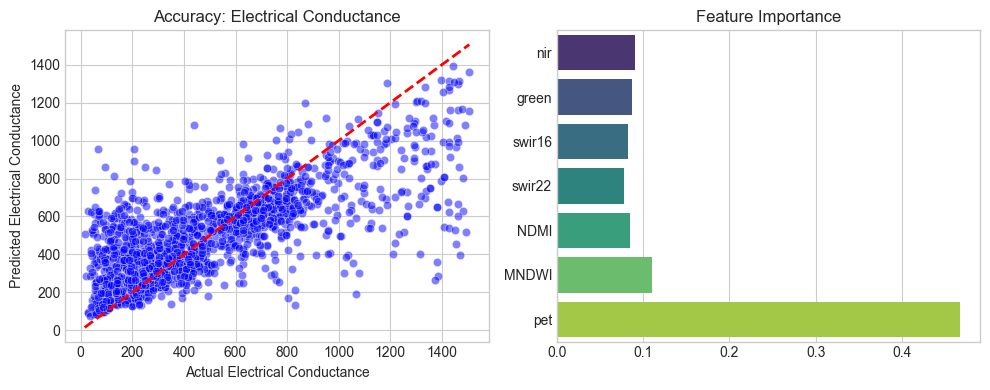

------------------------------------------------------------

🔹 TARGET: Dissolved Reactive Phosphorus
   Train R²: 0.8250  |  Train RMSE: 21.2356
   Test R² : 0.5427  |  Test RMSE: 35.0322
   Gap (Overfitting): 0.2823


/var/folders/hv/kxrxx3qn2rz5xqvmhb82grsw0000gn/T/ipykernel_2056/1368798169.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


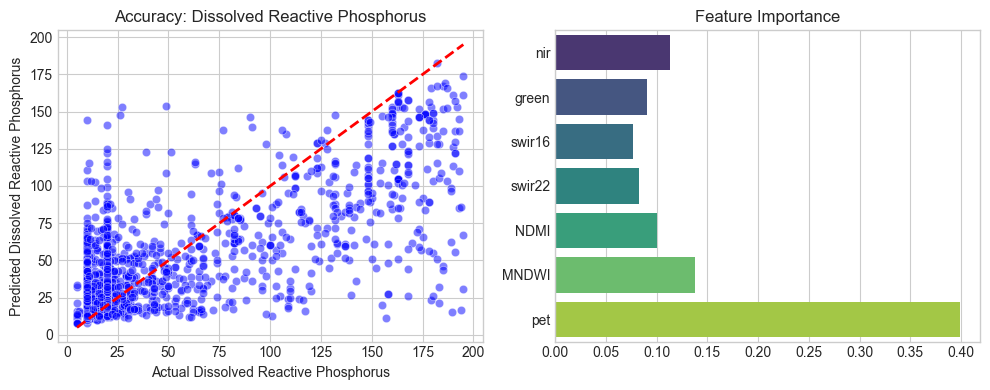

------------------------------------------------------------



In [16]:
plt.style.use('seaborn-v0_8-whitegrid')

print(f"{'='*60}")
print("       🚀 FINAL MODEL PERFORMANCE REPORT")
print(f"{'='*60}\n")

for target in targets:
    model = trained_models[target]
    
    # 1. Generate Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 2. Calculate Metrics
    train_r2 = r2_score(y_train[target], y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train[target], y_train_pred))
    
    test_r2 = r2_score(y_test[target], y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test[target], y_test_pred))
    
    # 3. Print Stats
    print(f"🔹 TARGET: {target}")
    print(f"   Train R²: {train_r2:.4f}  |  Train RMSE: {train_rmse:.4f}")
    print(f"   Test R² : {test_r2:.4f}  |  Test RMSE: {test_rmse:.4f}")
    print(f"   Gap (Overfitting): {train_r2 - test_r2:.4f}")
    
    # 4. Visual Check: Actual vs Predicted Plot
    plt.figure(figsize=(10, 4))
    
    # Subplot 1: Scatter Plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_test[target], y=y_test_pred, alpha=0.5, color='blue')
    plt.plot([y_test[target].min(), y_test[target].max()], 
             [y_test[target].min(), y_test[target].max()], 
             'r--', lw=2) # Perfect prediction line
    plt.xlabel(f'Actual {target}')
    plt.ylabel(f'Predicted {target}')
    plt.title(f'Accuracy: {target}')
    
    # Subplot 2: Feature Importance (What is the model actually learning?)
    plt.subplot(1, 2, 2)
    # Extract feature importance from the model inside the pipeline
    if hasattr(model, 'best_estimator_'):
        importances = model.best_estimator_.named_steps['model'].feature_importances_
    else:
        importances = model.named_steps['model'].feature_importances_
        
    features = feature_cols 
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
    print("-" * 60 + "\n")